In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from collections import Counter
import seaborn as sns

sns.set_theme()
sns.set_context("paper")
sns.set_palette("colorblind")

In [3]:
# Loading in SOPHIE Data
sophie80df = pd.read_csv("Data/SOPHIE_EPT80_1996-2022.csv", low_memory=False)
sophie80df['Date_UTC'] = pd.to_datetime(sophie80df['Date_UTC'])

array = np.zeros(len(sophie80df['Date_UTC']),dtype=int)
for i in range(4,len(sophie80df['Date_UTC'])-2):
    if (sophie80df.iloc[i-4]['Phase'] == 1) and (sophie80df.iloc[i-3]['Phase'] == 2) and (sophie80df.iloc[i-2]['Phase'] == 3) and (sophie80df.iloc[i-1]['Phase'] == 1) and (sophie80df.iloc[i]['Phase'] == 2) and (sophie80df.iloc[i+1]['Phase'] == 3) and (sophie80df.iloc[i+2]['Phase'] == 1) :
        array[i] = 1
        continue
    else:
        array[i] = 0
        continue

sophie80df['GERG'] = array

array = np.zeros(len(sophie80df['Date_UTC']),dtype=int)
for i in range(2,len(sophie80df['Date_UTC'])-1):
    if (sophie80df.iloc[i-2]['Phase'] == 2) and (sophie80df.iloc[i-1]['Phase'] == 3) and (sophie80df.iloc[i]['Phase'] == 2) and (sophie80df.iloc[i+1]['Phase'] == 3):
        array[i] = 1
        continue
    else:
        array[i] = 0
        continue

sophie80df['ERER'] = array

# choosing only sophie onsets
sophie80onsetdf = sophie80df.iloc[np.where(sophie80df['Phase']==2)]
sophie80onsetdf = sophie80onsetdf.reset_index(drop=True)
phaseafter = sophie80df['Date_UTC'].iloc[np.where(sophie80df[:-1]['Phase']==2)[0]+1].reset_index(drop=True) 
sophie80onsetdf['Duration'] = phaseafter - sophie80onsetdf['Date_UTC']
x = np.array(pd.to_timedelta(np.diff(sophie80onsetdf['Date_UTC'])))
x1 = np.insert(x,0,[pd.to_timedelta(0,'h')])
sophie80onsetdf['Waiting Time'] = x1
x2 = np.append(x,np.array([pd.to_timedelta(0,'h')],dtype=np.timedelta64))
sophie80onsetdf['Time to Next'] = x2
sophie80onsetdf['Delbay'] = pd.to_numeric(sophie80onsetdf['Delbay'],errors='coerce')

gerg = sophie80onsetdf.iloc[np.where(sophie80onsetdf['GERG']==1)]
erer = sophie80onsetdf.iloc[np.where(sophie80onsetdf['ERER']==1)]

gergnoflag = gerg.iloc[np.where(gerg['Flag']==0)]
erernoflag = erer.iloc[np.where(erer['Flag']==0)]

In [4]:
# Finding the indices of the first and last sophie onsets in a gerg
x = np.where(sophie80onsetdf['GERG']==1)[0]
y = x - 1
firstgerg = sophie80onsetdf.iloc[np.setdiff1d(y,x)]
lastgerg = sophie80onsetdf.iloc[np.setdiff1d(x,y)]

# Finding the indices of the first and last sophie onsets in a gerg
x = np.where(sophie80onsetdf['ERER']==1)[0]
y = x - 1
firster = sophie80onsetdf.iloc[np.setdiff1d(y,x)]
laster = sophie80onsetdf.iloc[np.setdiff1d(x,y)]

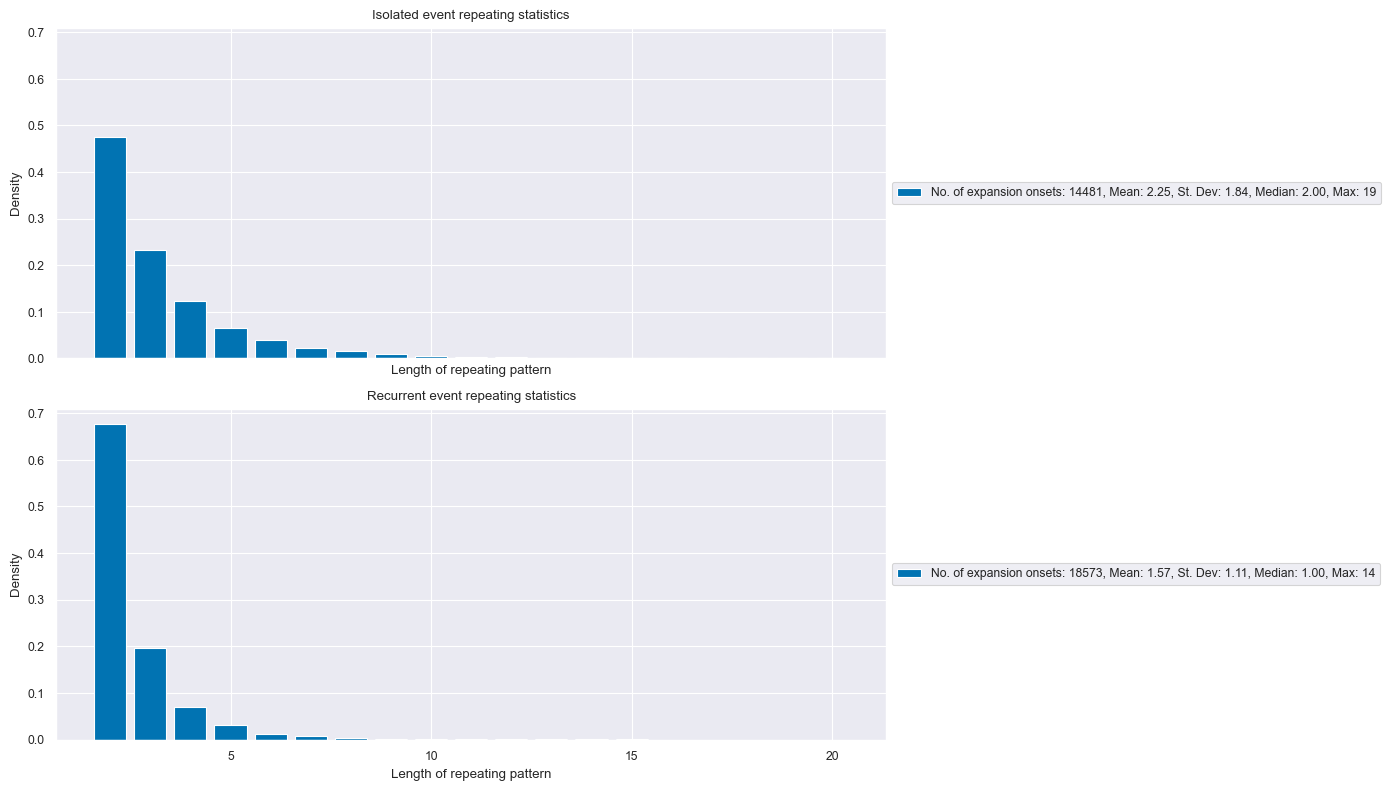

In [10]:
s = (sophie80onsetdf['GERG'] == 1) & (sophie80onsetdf['Flag'] == 0)
co = (~s).cumsum()[s].value_counts().to_list()
label = 'No. of expansion onsets: {}, Mean: {:.2f}, St. Dev: {:.2f}, Median: {:.2f}, Max: {}'.format(sum(co),np.mean(co), np.std(co), np.median(co), np.max(co))
y, x = np.histogram(co, bins=np.arange(1,np.max(co)+2,1),density=True)
x = x[:-1] + 1


fig, (ax, ax1) = plt.subplots(2,1, figsize=(14,8),sharex=True, sharey=True)

ax.bar(x,y,label=label)
ax.set_xlabel('Length of repeating pattern')
ax.set_ylabel('Density')
ax.set_title("Isolated event repeating statistics")
ax.legend(bbox_to_anchor=(1, .5), loc='center left')

s = (sophie80onsetdf['ERER'] == 1) & (sophie80onsetdf['Flag'] == 0)
co = (~s).cumsum()[s].value_counts().to_list()
label = 'No. of expansion onsets: {}, Mean: {:.2f}, St. Dev: {:.2f}, Median: {:.2f}, Max: {}'.format(sum(co),np.mean(co), np.std(co), np.median(co), np.max(co))
y, x = np.histogram(co, bins=np.arange(1,np.max(co)+2,1),density=True)
x = x[:-1] + 1

ax1.bar(x,y,label=label)
ax1.set_xlabel('Length of repeating pattern')
ax1.set_ylabel('Density')
ax1.set_title("Recurrent event repeating statistics")
ax1.legend(bbox_to_anchor=(1, .5), loc='center left')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(1))
fig.tight_layout()


In [6]:
def md_pt_end(x):
    dx = np.diff(x)
    return np.where(dx > 0)[0][0]

Text(0.5, 1.05, 'Isolated event repeating statistics')

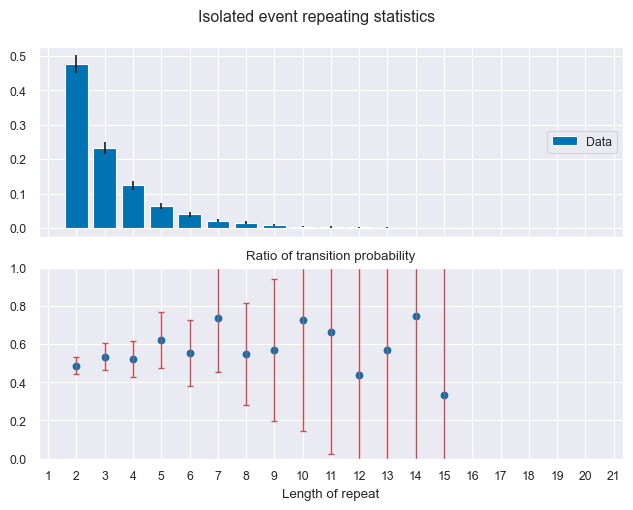

In [8]:
s = (sophie80onsetdf['GERG'] == 1) & (sophie80onsetdf['Flag'] == 0)
co = (~s).cumsum()[s].value_counts().to_list()

y, x = np.histogram(co, bins=np.arange(1,np.max(co)+2,1))
x = x[:-1] + 1
yerror = [np.sqrt(i) for i in y]

if np.where(y==0)[0].size > 0:
    yanalysis = y[:np.where(y==0)[0][0]+1]
else:
    yanalysis = y

yanalysis = yanalysis[:md_pt_end(yanalysis)+1]

yerror = yerror/np.sum(y)
yerror = 3*yerror
y = y/np.sum(y)
yanalysis = yanalysis/sum(yanalysis)


ratio = np.array([yanalysis[i]/yanalysis[i-1] for i in range(1,len(yanalysis))])
ratioerror = np.array([np.sqrt((yerror[i]/yanalysis[i])**2 + (yerror[i-1]/yanalysis[i-1])**2) for i in range(1,len(yanalysis))])
ratioerror = ratioerror*ratio

fig, (ax, ax1) = plt.subplots(2,1,sharex=True)

ax.bar(x,y,yerr=yerror,label='Data')
ax.legend(loc='center right')

ax1.scatter(x[:len(ratio)], ratio[:len(ratio)])
ax1.errorbar(x[:len(ratio)], ratio[:len(ratio)], yerr=ratioerror, fmt='none', ecolor='r', elinewidth=1, capsize=2)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set_xlabel("Length of repeat")
ax1.set_title("Ratio of transition probability")
ax1.set_ylim(0,1)

fig.tight_layout(pad=1)
fig.suptitle('Isolated event repeating statistics',y=1.05)


Text(0.5, 1.05, 'Recurrent event repeating statistics')

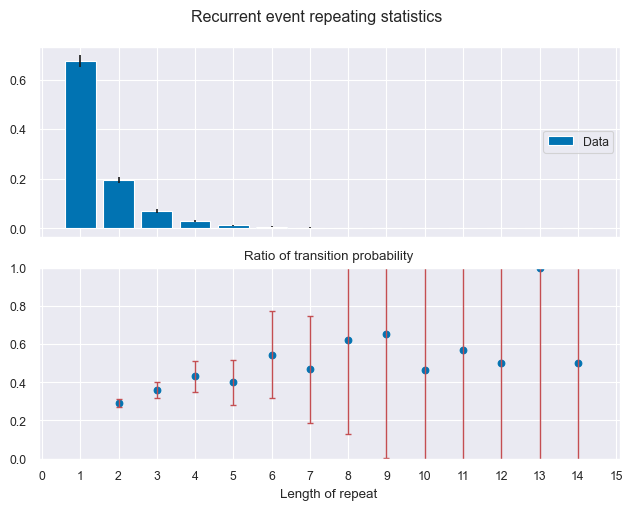

In [9]:
s = (sophie80onsetdf['ERER'] == 1) & (sophie80onsetdf['Flag'] == 0)
co = (~s).cumsum()[s].value_counts().to_list()

y, x = np.histogram(co, bins=np.arange(1,np.max(co)+2,1))
x = x[:-1] 
yerror = [np.sqrt(i) for i in y]

if np.where(y==0)[0].size > 0:
    yanalysis = y[:np.where(y==0)[0][0]]
else:
    yanalysis = y

yerror = yerror/np.sum(y)
yerror = 3*yerror
y = y/np.sum(y)
yanalysis = yanalysis/sum(yanalysis)


ratio = np.array([yanalysis[i]/yanalysis[i-1] for i in range(1,len(yanalysis))])
ratioerror = np.array([np.sqrt((yerror[i]/yanalysis[i])**2 + (yerror[i-1]/yanalysis[i-1])**2) for i in range(1,len(yanalysis))])
ratioerror = ratioerror*ratio

fig, (ax, ax1) = plt.subplots(2,1,sharex=True)

ax.bar(x,y,yerr=yerror,label='Data')
ax.legend(loc='center right')

ax1.scatter(x[1:len(ratio)+1], ratio[:len(ratio)])
ax1.errorbar(x[1:len(ratio)+1], ratio[:len(ratio)], yerr=ratioerror, fmt='none', ecolor='r', elinewidth=1, capsize=2)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set_xlabel("Length of repeat")
ax1.set_title("Ratio of transition probability")
ax1.set_ylim(0,1)

fig.tight_layout(pad=1)
fig.suptitle("Recurrent event repeating statistics", y=1.05)


In [ ]:
def waitingtime_hist(array):
    x, y = np.histogram(array['Waiting Time']/pd.to_timedelta(1,'h'),bins=np.arange(0,12.25,.25))
    y = y+.125
    y = y[:-1]
    d = {'Waiting Time':y,'Density':x/np.sum(x)}
    df = pd.DataFrame(d)
    return df


onsetlists = [sophie80onsetdf, gergnoflag, erernoflag]
labels = ['SOPHIE EPT80 All', 'SOPHIE EPT80 G|ERG|ERG','SOPHIE EPT80 |ER|ER']
onsetnumbers = [len(i) for i in onsetlists]
means = [np.mean(i['Waiting Time'])/pd.Timedelta(1,'h') for i in onsetlists]
stdevs = [np.std(i['Waiting Time'])/pd.Timedelta(1,'h') for i in onsetlists]
medians = [np.median(i['Waiting Time'])/pd.Timedelta(1,'h') for i in onsetlists]
labels = ["{}, {} onsets, mean:  {:.2f}, st. dev: {:.2f}, median: {:.2f}".format(labels[i],onsetnumbers[i],means[i],stdevs[i],medians[i]) for i in range(len(onsetlists))]

lines = ['solid','dashed','dashdot']
wts = [waitingtime_hist(i) for i in onsetlists]
fig, axes = plt.subplots(figsize=(8,8))

for i in range(len(onsetlists)):
    axes.plot(wts[i]['Waiting Time'],wts[i]['Density'], label=labels[i], ls=lines[i])
    
axes.xaxis.set_minor_locator(ticker.MultipleLocator(1))
axes.set_xlabel('Waiting time (hours)')
axes.grid(True,'both')
fig.suptitle('Substorm waiting time distribution', fontsize=16, y=1)
fig.legend(bbox_to_anchor=(1, .5), loc='center left')
fig.tight_layout()

In [ ]:
def duration_hist(array):
    x, y = np.histogram(array['Duration']/pd.to_timedelta(1,'m'),bins=np.arange(0,120,1))
    y = y+.5
    y = y[:-1]
    d = {'Duration':y,'Density':x/np.sum(x)}
    df = pd.DataFrame(d)
    return df

onsetlists = [sophie80onsetdf, gergnoflag, erernoflag]
labels = ['SOPHIE EPT80 All', 'SOPHIE EPT80 G|ERG|ERG','SOPHIE EPT80 |ER|ER']
onsetnumbers = [len(i) for i in onsetlists]
means = [np.mean(i['Duration'])/pd.Timedelta(1,'m') for i in onsetlists]
stdevs = [np.std(i['Duration'])/pd.Timedelta(1,'m') for i in onsetlists]
medians = [np.median(i['Duration'])/pd.Timedelta(1,'m') for i in onsetlists]
labels = ["{}, {} onsets, mean:  {:.2f}, st. dev: {:.2f}, median: {:.2f}".format(labels[i],onsetnumbers[i],means[i],stdevs[i],medians[i]) for i in range(len(onsetlists))]

lines = ['solid','dashed','dashdot']
wts = [duration_hist(i) for i in onsetlists]
fig, axes = plt.subplots(figsize=(8,8))

for i in range(len(onsetlists)):
    axes.plot(wts[i]['Duration'],wts[i]['Density'], label=labels[i], ls=lines[i])
    

axes.set_xlabel('Expansion Duration (mins)')
axes.grid(True,'both')
fig.suptitle('Substorm Expansion Duration distribution', fontsize=16, y=1)
fig.legend(bbox_to_anchor=(1, .5), loc='center left')
fig.tight_layout()

In [ ]:
def size_hist(array):
    x, y = np.histogram(-array['Delbay'],bins=np.arange(0,1000,25))
    y = y + 12.5
    y = y[:-1]
    d = {'Size':y,'Density':x/np.sum(x)}
    df = pd.DataFrame(d)
    return df

onsetlists = [sophie80onsetdf, gergnoflag, erernoflag]
labels = ['SOPHIE EPT80 All', 'SOPHIE EPT80 G|ERG|ERG','SOPHIE EPT80 |ER|ER']
onsetnumbers = [len(i) for i in onsetlists]
means = [np.nanmean(-i['Delbay']) for i in onsetlists]
stdevs = [np.nanstd(-i['Delbay']) for i in onsetlists]
medians = [np.nanmedian(-i['Delbay']) for i in onsetlists]
labels = ["{}, {} onsets, mean:  {:.2f}, st. dev: {:.2f}, median: {:.2f}".format(labels[i],onsetnumbers[i],means[i],stdevs[i],medians[i]) for i in range(len(onsetlists))]

lines = ['solid','dashed','dashdot']
wts = [size_hist(i) for i in onsetlists]
fig, axes = plt.subplots(figsize=(8,8))

for i in range(len(onsetlists)):
    axes.plot(wts[i]['Size'],wts[i]['Density'], label=labels[i],ls=lines[i])
    
axes.set_xlabel('Substorm Size (nT)')
axes.grid(True,'both')
fig.suptitle('Substorm Size distribution', fontsize=16, y=1)
fig.legend(bbox_to_anchor=(1, .5), loc='center left')
fig.tight_layout()

In [ ]:
def mlat_hist(array):
    x, y = np.histogram(array['MLat'],bins=np.arange(40,85,1))
    y = y + .5
    y = y[:-1]
    d = {'MLat':y,'Density':x/np.sum(x)}
    df = pd.DataFrame(d)
    return df

onsetlists = [sophie80onsetdf, gerg, erer]
labels = ['SOPHIE EPT80 All', 'SOPHIE EPT80 GERG|ERG','SOPHIE EPT80 ER|ER']
onsetnumbers = [len(i) for i in onsetlists]
means = [np.mean(i['MLat']) for i in onsetlists]
stdevs = [np.std(i['MLat']) for i in onsetlists]
medians = [np.median(i['MLat']) for i in onsetlists]
labels = ["{}, {} onsets, mean:  {:.2f}, st. dev: {:.2f}, median: {:.2f}".format(labels[i],onsetnumbers[i],means[i],stdevs[i],medians[i]) for i in range(len(onsetlists))]

lines = ['solid','dashed','dashdot']
wts = [mlat_hist(i) for i in onsetlists]
fig, axes = plt.subplots(figsize=(8,8))

for i in range(len(onsetlists)):
    axes.plot(wts[i]['MLat'],wts[i]['Density'], label=labels[i],ls=lines[i])
    

axes.set_xlim(40,85)
axes.set_xlabel('Substorm Onset Location (MLat)')
axes.grid(True,'both')
fig.suptitle('Substorm MLat distribution', fontsize=16, y=1)
fig.legend(bbox_to_anchor=(1, .5), loc='center left')
fig.tight_layout()


In [ ]:
def mlt_hist(array):
    x, y = np.histogram(array['MLT'],bins=np.arange(0,24,.5))
    y = y + .25
    y = y[:-1]
    d = {'MLT':y,'Density':x/np.sum(x)}
    df = pd.DataFrame(d)
    return df

onsetlists = [sophie80onsetdf, gerg, erer]
labels = ['SOPHIE EPT80 All', 'SOPHIE EPT80 GERG|ERG','SOPHIE EPT80 ER|ER']
onsetnumbers = [len(i) for i in onsetlists]
means = [np.mean(i['MLT']) for i in onsetlists]
stdevs = [np.std(i['MLT']) for i in onsetlists]
medians = [np.median(i['MLT']) for i in onsetlists]
labels = ["{}, {} onsets, mean:  {:.2f}, st. dev: {:.2f}, median: {:.2f}".format(labels[i],onsetnumbers[i],means[i],stdevs[i],medians[i]) for i in range(len(onsetlists))]

lines = ['solid','dashed','dashdot']
wts = [mlt_hist(i) for i in onsetlists]
fig, axes = plt.subplots(figsize=(8,8))

for i in range(len(onsetlists)):
    axes.plot(wts[i]['MLT'],wts[i]['Density'], label=labels[i],ls=lines[i])
    

axes.set_xlim(0,24)
axes.set_xlabel('Substorm Onset Location MLT')
axes.grid(True,'both')
fig.suptitle('Substorm MLT distribution', fontsize=16, y=1)
fig.legend(bbox_to_anchor=(1, .5), loc='center left')
fig.tight_layout()
